In [61]:
import numpy as np
import scipy as sp
import math
from scipy.ndimage import interpolation
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from time import time

# **Load Data**

In [38]:
#download the 4 .gz data files, uncompress and put in folder data/

def read_data(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    f.close()
    l.close()
    df = pd.DataFrame(images)
    df.rename(columns = {0:'label'}, inplace = True) 
    return df

data_train = read_data("data/train-images-idx3-ubyte", "data/train-labels-idx1-ubyte",
        "mnist_train.csv", 60000)
data_test = read_data("data/t10k-images-idx3-ubyte", "data/t10k-labels-idx1-ubyte",
        "mnist_test.csv", 10000)

In [112]:
X_train = data_train.drop(['label'], axis='columns', inplace=False)
Y_train = data_train['label']
X_test = data_test.drop(['label'], axis='columns', inplace=False)
Y_test = data_test['label']

# X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.25, 
#                                                     stratify=labels, random_state=30)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

train feature shape:  (60000, 784)
test feature shape:  (10000, 784)


Class distribution:

In [99]:
data_train['label'].value_counts(normalize=True) * 100

1    11.236667
7    10.441667
3    10.218333
2     9.930000
9     9.915000
0     9.871667
6     9.863333
8     9.751667
4     9.736667
5     9.035000
Name: label, dtype: float64

Visulisation of the data:

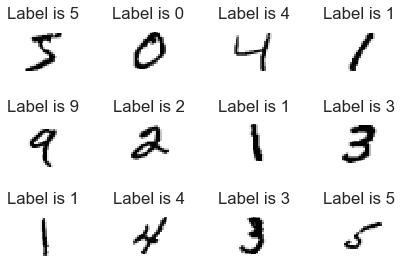

In [100]:
def plot_number(row, w=28, h=28):
    label = row['label']
    pixels = row[1:]

    # Make those columns into a array of 8-bits pixels
    # This array will be of 1D with length 784
    # The pixel intensity values are integers from 0 to 255
    pixels = 255-np.array(pixels, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((w, h))

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')


def plot_slice(rows, size_w=28, size_h=28):
    num = rows.shape[0]
    w = 4
    h = math.ceil(num / w)
    fig, plots = plt.subplots(h, w)
    fig.tight_layout()

    for n in range(0, num):
        s = plt.subplot(h, w, n+1)
        s.set_xticks(())
        s.set_yticks(())
        plot_number(rows.iloc[n], size_w, size_h)
    plt.show()
    
plot_slice(data_train[0:12])

Deskew the images:

In [101]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    return (img - img.min()) / (img.max() - img.min())

def deskew_vectorize(images):
    """Deskew matrix of N MNIST sample
    :images: Matrix size (N, 784)
    :returns: Matrix size (N, 28, 28)
    """
    N = images.shape[0]
    reshaped_images = images.reshape(N , 28, 28)
    deskewed_images = np.array(list(map(deskew, reshaped_images)))

    return deskewed_images.reshape(N, 784)

X_train_deskewed = deskew_vectorize(X_train.values)
X_test_deskewed = deskew_vectorize(X_test.values)

In [102]:
from skimage.transform import resize

def enlarge_figure(pixel_vector):
    X_array = pixel_vector.reshape((28,28))
    Threshold = sum(X_array[0])+ 250#255
    top = 0
    #Threshold = 28*min(X_array[up])
    Temp = sum(X_array[top])
    while Temp <= Threshold:
        top = top+1
        Temp = sum(X_array[top])
        
    bottom = 27
    #Threshold = 28*min(X_array[down])
    Temp = sum(X_array[bottom])
    while Temp <= Threshold:
        bottom = bottom-1
        Temp = sum(X_array[bottom])
        
    left = 0
    #Threshold = 28*min(X_array[:,left])
    Temp = sum(X_array[:,left])
    while Temp <= Threshold:
        left = left+1
        Temp = sum(X_array[:,left])
        
    right = 27
    #Threshold = 28*min(X_array[:,right])
    Temp = sum(X_array[:,right])
    while Temp <= Threshold:
        right = right-1
        Temp = sum(X_array[:,right])
        
    X_array = X_array[top:(bottom+1),left:(right+1)]
    #print(X_refine)
    X_array = resize(X_array, (28, 28),preserve_range=True,mode='constant')
    X_array = X_array.astype('uint8')
    #print(X_refine_resize)
    pixel_vector = X_array.reshape((1,784))
    #plot_Figure_Deskewed(pixel_vector)
    
    return pixel_vector

def enlarge_data(X_df,h,w=784):
    X_array = X_df.to_numpy(dtype='uint16')
    X_enlarge = X_array
    for i in range(h):
        X_enlarge[i] = enlarge_figure(X_array[i])
    X_enlarge = pd.DataFrame(X_enlarge)
    X_enlarge.columns = X_enlarge.columns+1
    return X_enlarge


X_train_deskew_df = pd.DataFrame(X_train_deskewed)
X_train_deskew_df.columns = X_train_deskew_df.columns+1
X_test_deskew_df = pd.DataFrame(X_test_deskewed)
X_test_deskew_df.columns = X_test_deskew_df.columns+1

t0 = time()
X_train = enlarge_data(X_train_deskew_df*255,h=60000)
X_test = enlarge_data(X_test_deskew_df*255,h=10000)
print("done in %0.3fs" % (time() - t0))

done in 69.004s


# **HOG**

In [71]:
def calculate_hog_features(images):
    list_hog_fd = [hog(t.reshape((28, 28)), orientations=9, pixels_per_cell=(2, 2), cells_per_block=(2, 2),
                       visualize=False) for t in images]

    return np.array(list_hog_fd, dtype=np.float64)
    hog_features.append(fd)
    
X_train = calculate_hog_features(X_train_deskewed)
X_test = calculate_hog_features(X_test_deskewed)

<Figure size 640x480 with 0 Axes>

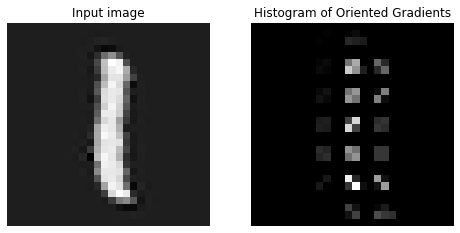

In [110]:
from skimage import data, exposure
figure(num=None, figsize=(8, 6), dpi=80)

fd, hog_image = hog(X_train_deskewed[3].reshape((28, 28)), orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2),
                       visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(conver_to_img(X_train_deskewed[3]), cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hogImage = exposure.rescale_intensity(hog_image, out_range=(0, 255))
hog_image_rescaled = hogImage.astype("uint8")

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.savefig('foo.png')
plt.show()


In [72]:
X_train.shape

(60000, 324)

# **PCA**

Use MinMaxScaler to standardize the data:

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
https://www.quora.com/Which-advantages-does-MinMax-scaling-have-over-a-standard-scaling-using-the-mean-and-the-standard-deviation

Compare MinMaxScaler to StandardScaler?

In [103]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

First visualize by choosing only 2 components:

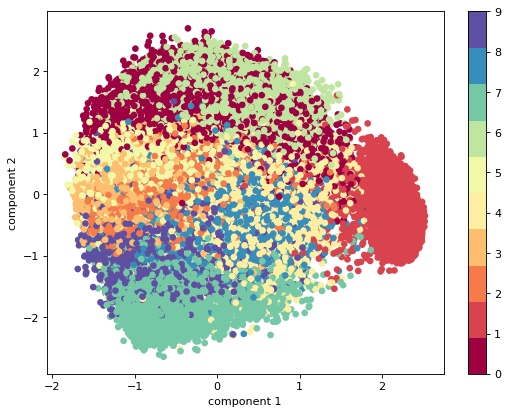

In [52]:
figure(num=None, figsize=(8, 6), dpi=80)

n_components = 2
pca = PCA(n_components=n_components,
          whiten=True).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
            c=Y_train, edgecolor='none',
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

plt.savefig('foo.png')

Now we decide the number of components:

In [97]:
n_components = 144
pca = PCA(n_components=n_components)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
print(pca.n_components_)

var=np.cumsum(pca.explained_variance_ratio_*100)

144


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


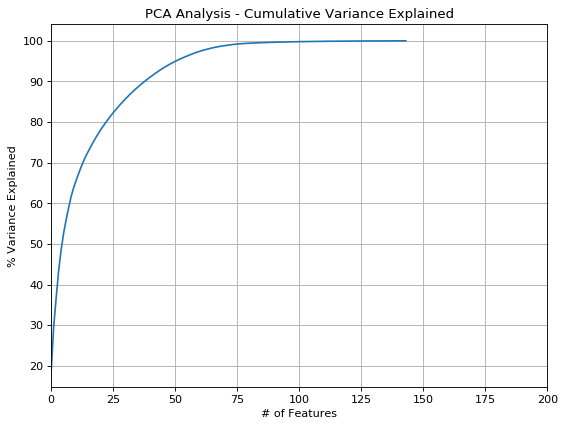

In [54]:
figure(num=None, figsize=(8, 6), dpi=80)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis - Cumulative Variance Explained')
plt.xlim(0,200)
plt.yticks(np.arange(0, 100.5, step=10))
plt.style.context('seaborn-whitegrid')
ax = plt.axes()
ax.grid()
plt.plot(var);

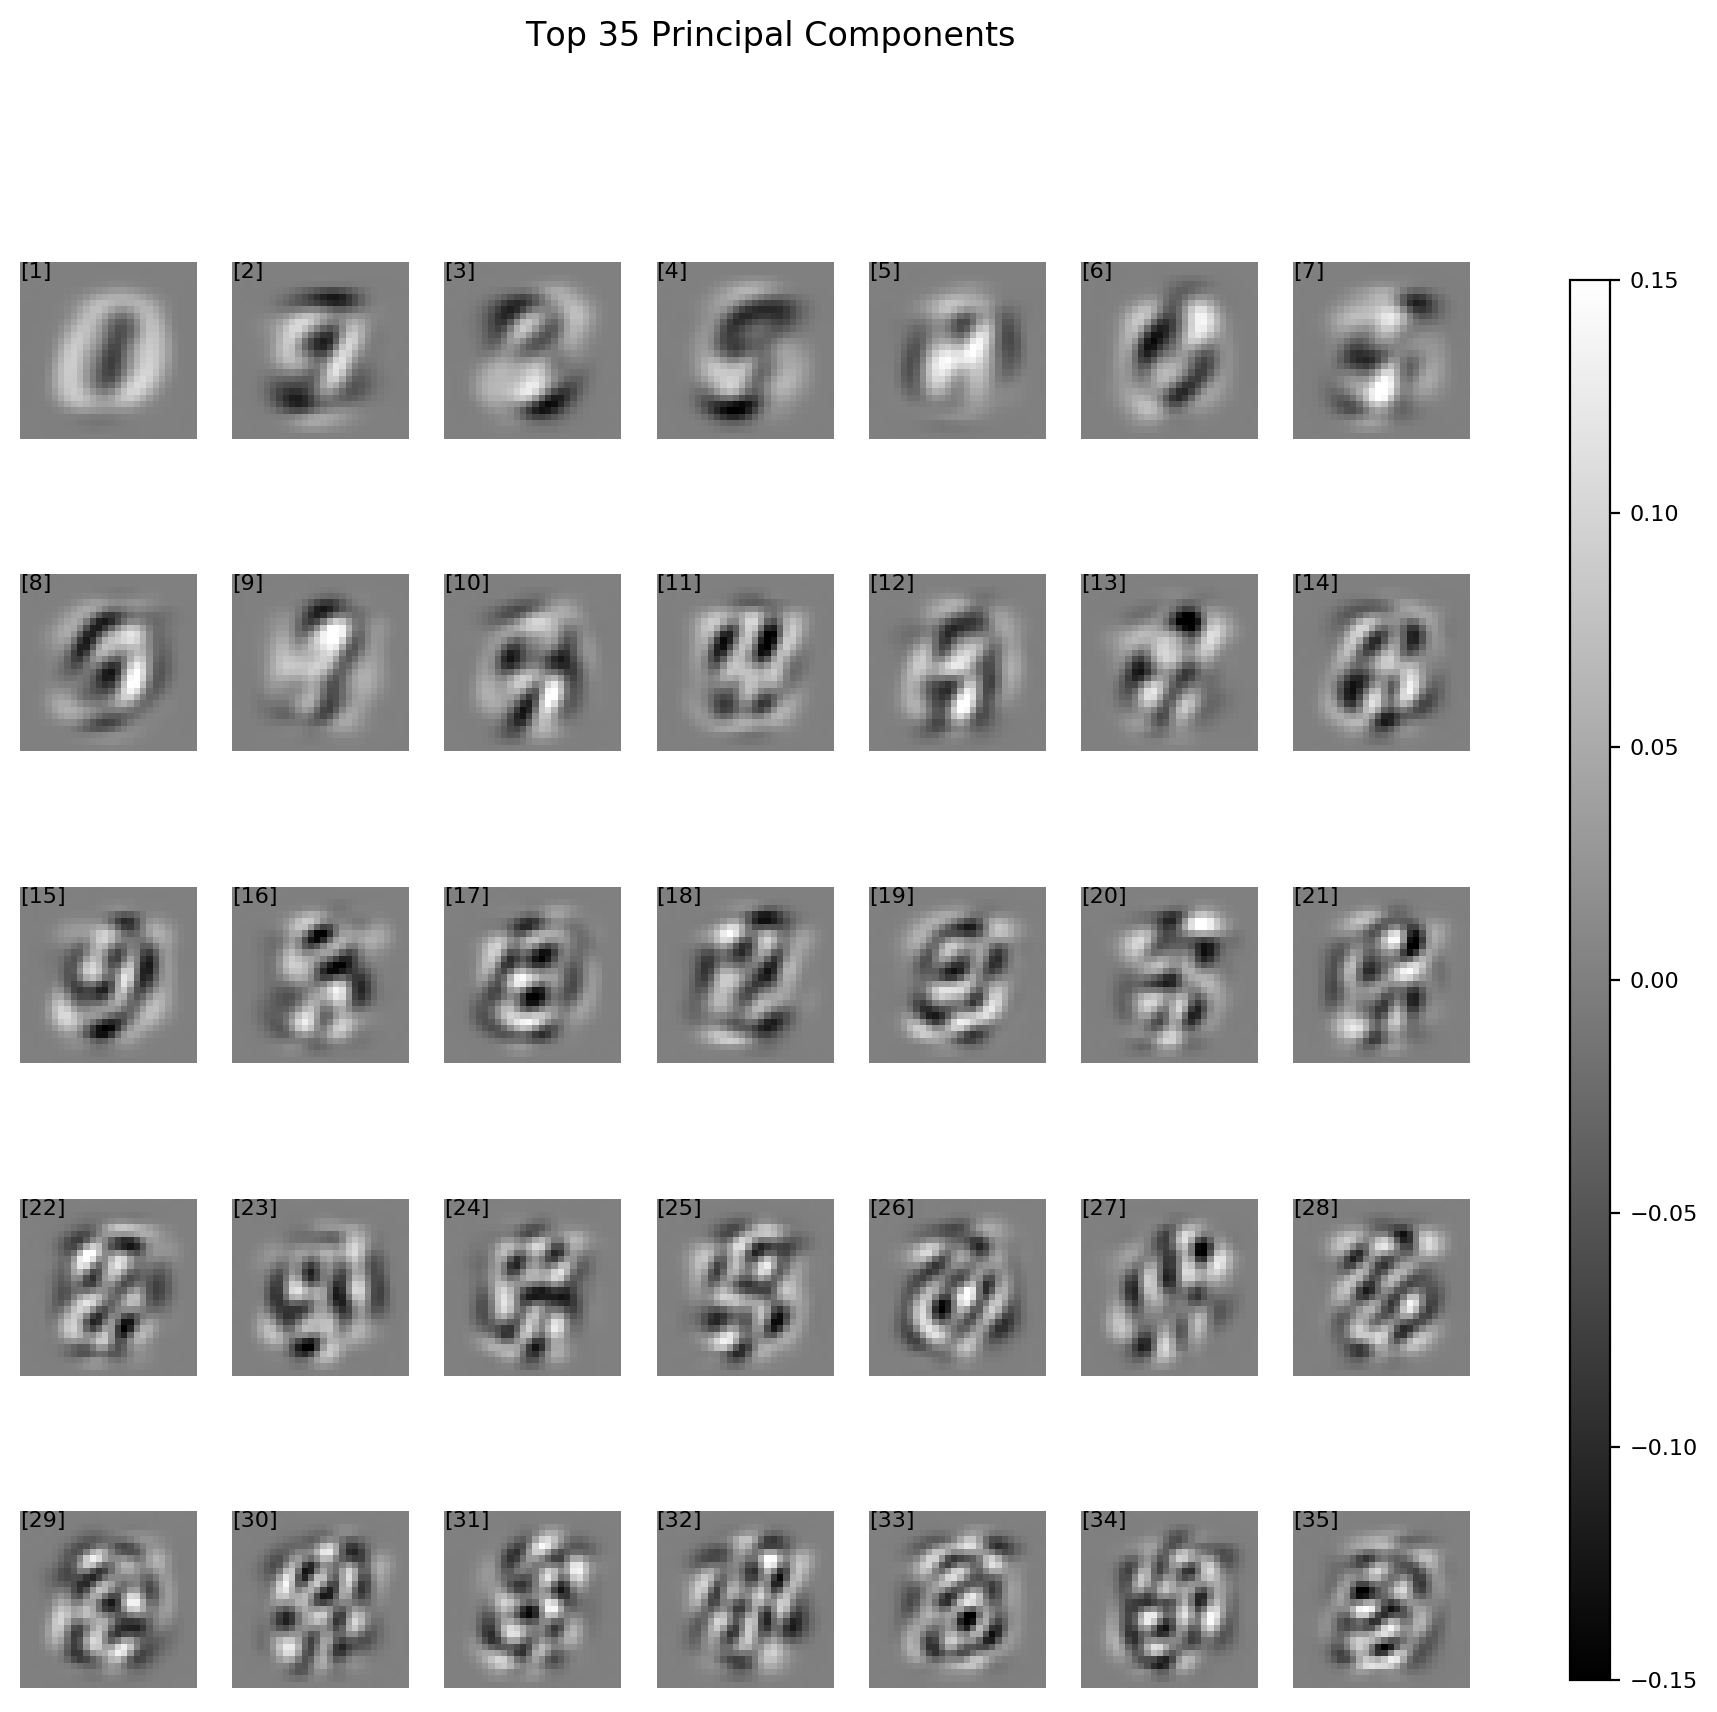

In [98]:
PIXEL = 28  # number of pixels per side

def conver_to_img(x):
    """ Reshape the 784 features into an imnage (28*28 2-D array)
        Output array have the same number of samples as x
    """
    if len(x.shape) == 2:  # multiplte rows samples
        return x.reshape(x.shape[0], PIXEL, PIXEL)
    return x.reshape(PIXEL, PIXEL)  # one row sample

def plot_main_pca(pca_model, row=3, col=5, cmap='gist_gray'):
    """plot the main PCA eigenvectors as images """
    n = pca_model.n_components_
    row = int(min(row, n//col + (n%col != 0)))
    n_pca = min(row * col, n)
    eigenvectors = pca_model.components_
    imgs = conver_to_img(eigenvectors[:n_pca])
    # vmin, vmax = np.min(imgs), np.max(imgs)
    fig, axes = plt.subplots(row, col, dpi=200)
    plt.suptitle("Top {} Principal Components".format(n_pca))

    for i in range(row*col):
        plt.subplot(row, col, i+1)
        if i < len(imgs):
            plt.imshow(imgs[i], cmap=cmap, vmin=-0.15, vmax=0.15)
            plt.annotate("[{0}]".format(i+1), size=8,
                         xy=(0, 1), xycoords='axes fraction',
                         va='top', ha='left')
        plt.axis('off')    

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(cax=cbar_ax)
    cbar.ax.tick_params(labelsize=8)
    plt.savefig('foo.png')
    plt.show()

    return

plot_main_pca(pca, row=5, col=7)

In [104]:
n_components = 50
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

# **SVM**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

param_grid = { "C" : [2, 5, 7]
              , "gamma" : [0.01, 0.02, 0.03, 0.05]}

t0 = time()
rf = SVC()
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
gs = gs.fit(X_train_pca, Y_train)
print("done in %0.3fs" % (time() - t0))

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [105]:
# bp = gs.best_params_

t0 = time()
#clf = SVC(C=bp['C'], kernel='rbf', gamma=bp['gamma'])
clf = SVC(C=5, kernel='rbf', gamma=0.02)
clf = clf.fit(X_train_pca, Y_train)
print("done in %0.3fs" % (time() - t0))

done in 58.263s


In [106]:
scaler = MinMaxScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
Y_predict= clf.predict(X_test_pca)
clf.score(X_test_pca, Y_test)

0.9904

Confusion matrix:

Confusion matrix, without normalization
[[ 975    0    1    0    0    0    3    1    0    0]
 [   0 1126    4    0    0    0    1    3    1    0]
 [   1    0 1022    0    3    0    0    4    2    0]
 [   0    0    2 1004    0    1    0    1    2    0]
 [   0    0    1    0  976    0    1    0    1    3]
 [   1    0    2    3    0  882    3    0    1    0]
 [   2    1    0    0    3    1  951    0    0    0]
 [   0    0    7    1    6    1    0 1013    0    0]
 [   1    0    2    2    1    2    1    2  963    0]
 [   2    0    1    1    5    2    0    4    2  992]]
Confusion matrix, without normalization
AxesSubplot(0.0530208,0.0233333;0.745583x0.961667)


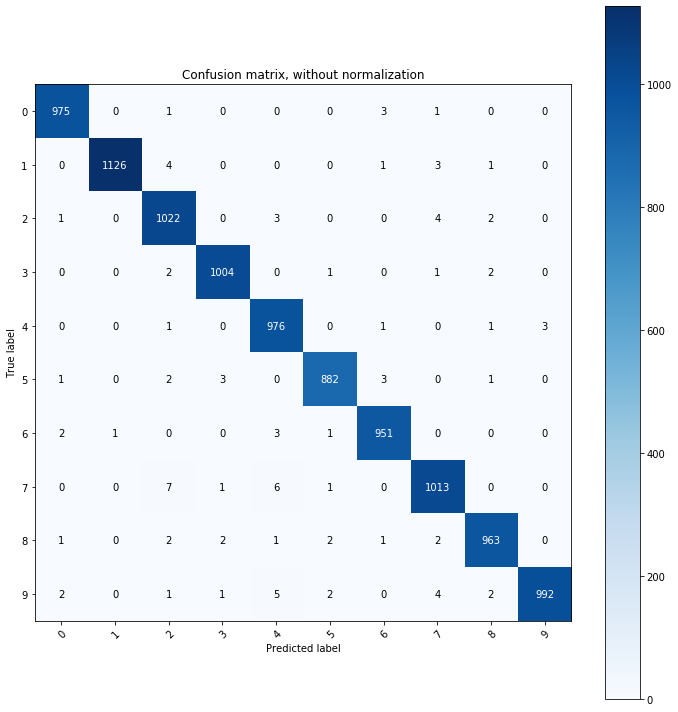

In [107]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.grid(None) 
    plt.rcParams["figure.figsize"] = (10,10)
    return ax

np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None)]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(Y_test, Y_predict, clf.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

    print(title)
    print(disp)
    
plt.show();

Misclassified images:

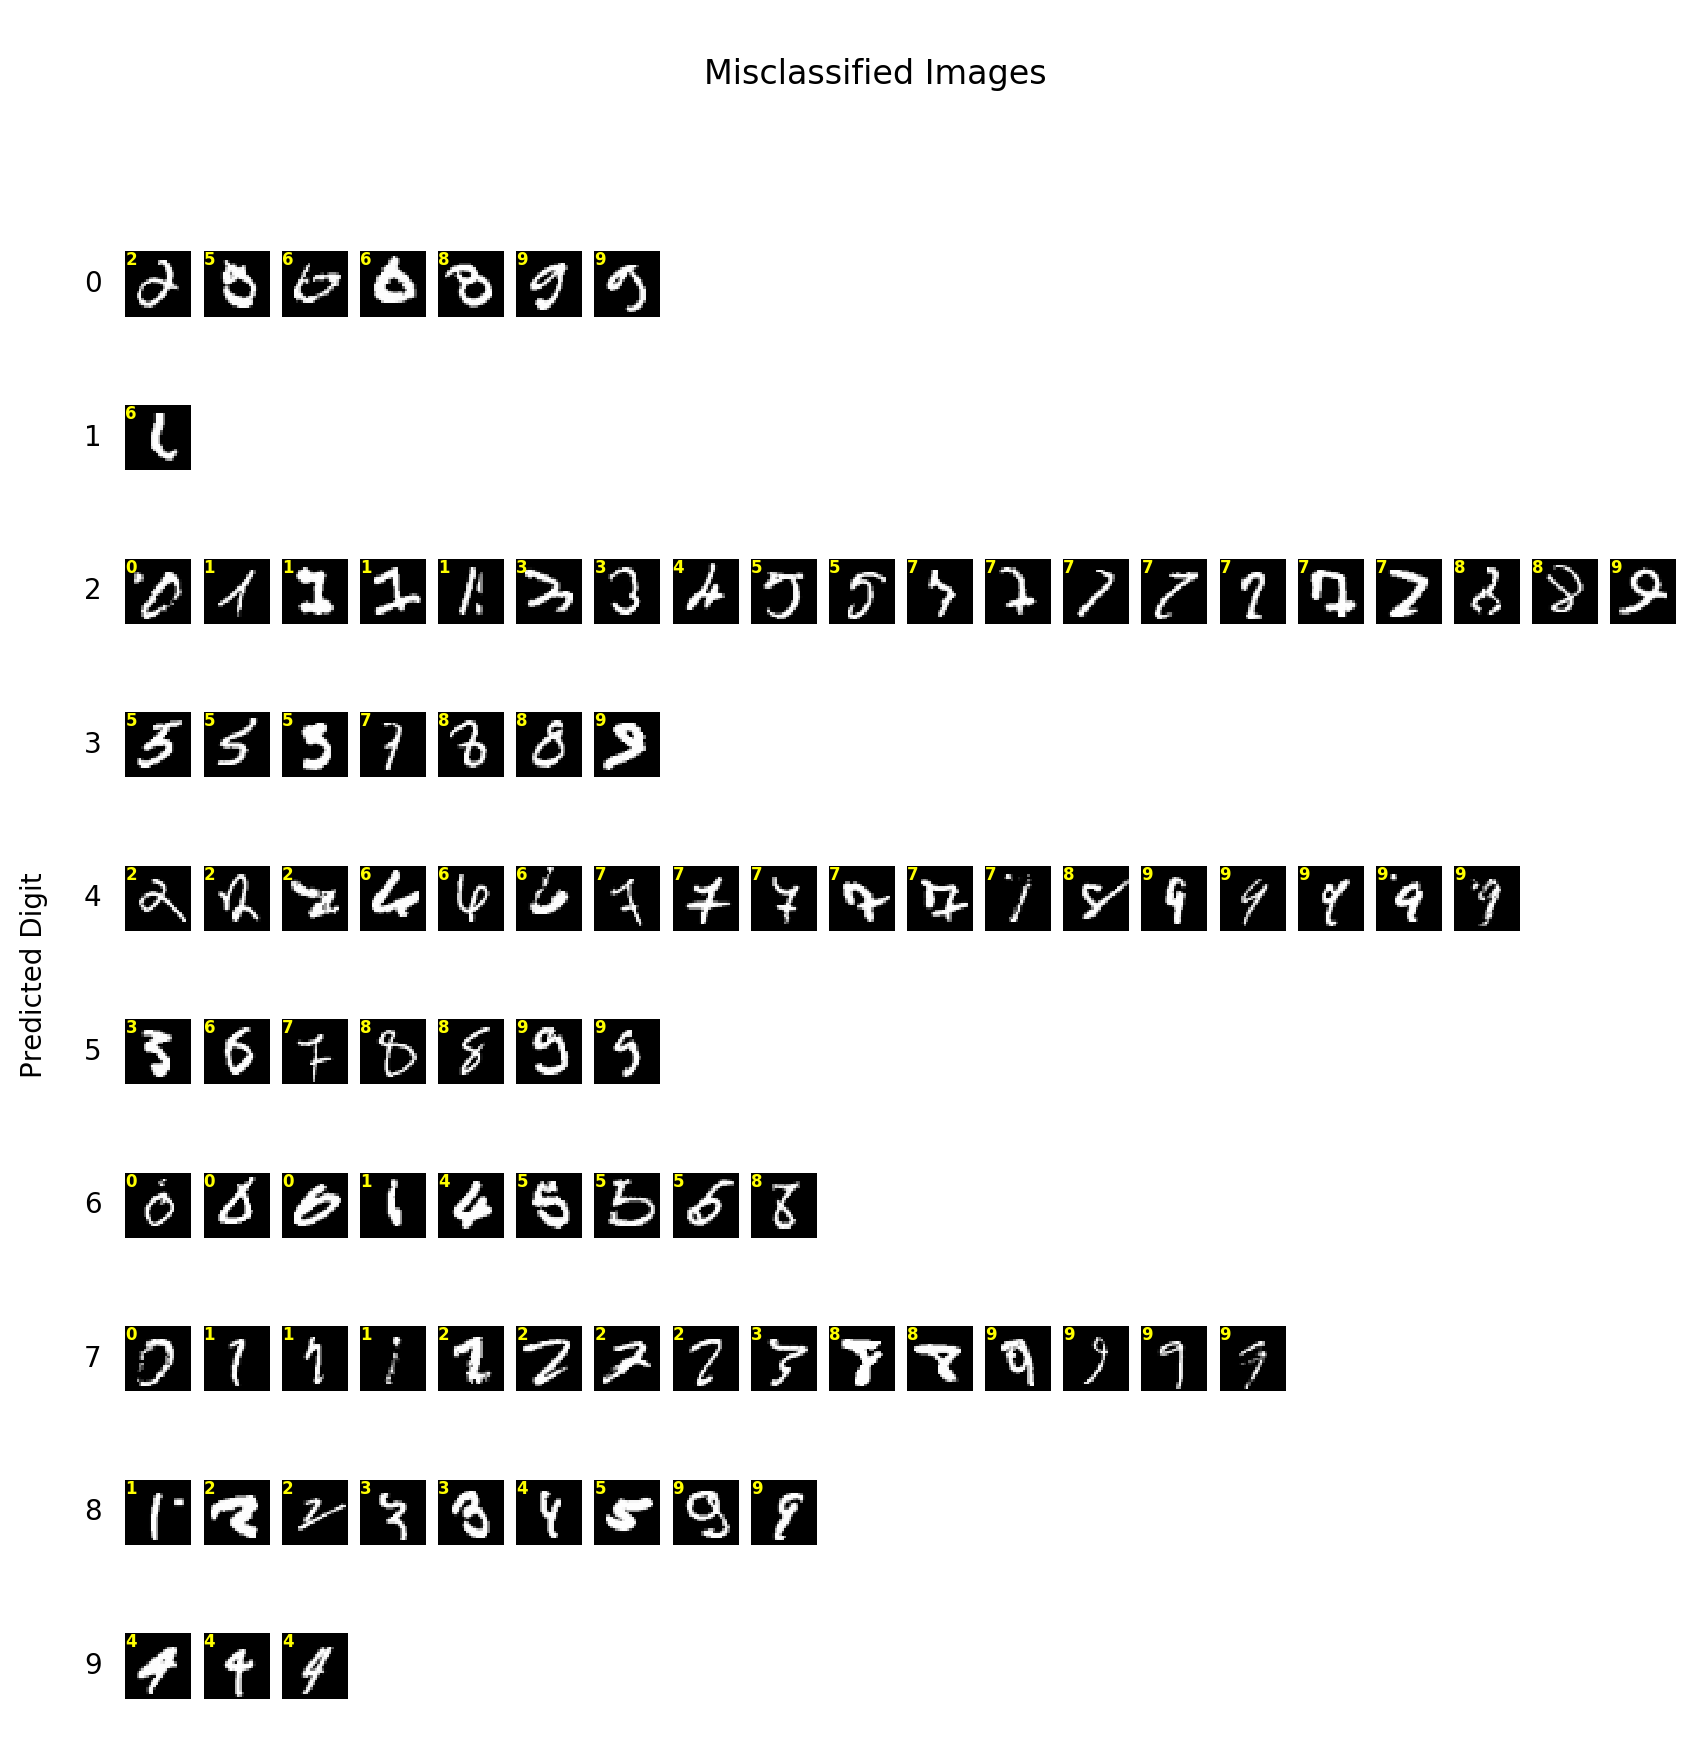

In [113]:
N_CLASSES = 10
LABELS = list(range(N_CLASSES))

def plot_misclassified_img(X_input, predicted, actual, n_cols=20, 
                           label_actual=True, sort=True, figtitle=""):
    misclass_idx = np.where(predicted != actual)[0]
    idx_dict = {i: [] for i in LABELS}
    # key: predicted class, val: list of idx
    for idx in misclass_idx:
        idx_dict[predicted[idx]].append(idx)
    for i in LABELS: 
        if sort:  # sort by actual class
            idx_dict[i].sort(key=lambda x: actual[x])
        else:  # shuffle
            np.random.shuffle(idx_dict[i])
    
    fig, axes = plt.subplots(N_CLASSES, n_cols, dpi=200)
    for row in LABELS:
        for col in range(n_cols):
            if col < len(idx_dict[row]):
                i = idx_dict[row][col]
                img = conver_to_img(X_input.values[i])
                axes[row, col].imshow(img, cmap='Greys_r')
                if label_actual:
                    axes[row, col].annotate(actual[i], xy=(0, 1), size=6, weight='bold',
                                        color='yellow', xycoords='axes fraction',
                                        horizontalalignment='left', verticalalignment='top')              
            axes[row, col].axis('off')
            
    for row in LABELS:
        axes[row, 0].annotate("{0}".format(row), size=10, xy=(-0.5, 0.5), 
                              horizontalalignment='center', verticalalignment='center',
                              xycoords='axes fraction')
    
    plt.suptitle(figtitle + "\nMisclassified Images")
    ax = fig.add_subplot(111, frameon=False)
    ax.axis('off')
    ax.annotate('Predicted Digit', xy=(-0.05, 0.5), xycoords='axes fraction',
                ha='right', va='center', rotation='vertical')
    plt.savefig('foo.png')
    plt.show()
    
    return

plot_misclassified_img(X_test, Y_predict, Y_test)

# **LDA**